In [1]:
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from src.load_covid19 import load_clean_covid19

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression

In [2]:
current_dir = os.getcwd()
file_path = os.path.join(os.path.dirname(current_dir), "data", "raw", "covid19-dataset", "Covid Data.csv")
df = pd.read_csv(file_path)

In [3]:
def get_scores(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    return acc, f1, prec, rec

In [4]:
#Wir fügen zuerst ein neues Attribut hinzu, das angibt, ob die Person gestorben ist oder nicht. 
#Die Verschlüsselung erfolgt konsistent mit den anderen Attributen (2 für "nein", 1 für "ja").
#Das Todesdatum wird als Attribut verworfen. 

df['DIED'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]
df=df.drop(columns='DATE_DIED')

In [5]:
#Eine Analyse der Missing Values zeigt, dass diese vor allem in den Spalten "PREGNANT", "ICU" und "INTUBED" vorkommen.
#Das Attribut "PREGNANT" wird bei allen männlichen Patienten auf 2 gesetzt.
#Das Attribut "PATIENT_TYPE" gibt an, ob die Person hospitalisiert war oder nicht. Bei allen Patienten ohne
#Krankenhausaufenthalt kann das Attribut "ICU" auf 2 gesetzt werden, da keiner dieser Patienten folglich auf
#einer Intensivstation behandelt wurde. 
#Dieselbe Vorgehensweise wenden wir auf das Attribut "INTUBED" an. Dazu gehen wir von der Grundannahme aus, dass
#ein Anschluss an ein Beatmungsgerät im Rahmen eines Klinikaufenthaltes erfolgt. Etwaige Fälle von Heimintubation 
#vernachlässigen wir dabei. 

df.loc[df.SEX==2,'PREGNANT']=2
df.loc[df.PATIENT_TYPE==1,'ICU']=2
df.loc[df.PATIENT_TYPE==1,'INTUBED']=2

In [6]:
#Für die anderen fehlenden Werte können keine sinnvollen Aussagen getroffen werden. Da sie nur einen sehr kleinen
#Anteil des gesamten Datensatzes ausmachen (2.76%), verwerfen wir sie. 

for col in df.columns.drop('AGE'):
    for i in [97,98, 99]:
        df[col]=df[col].replace(i , np.nan)

df=df.dropna()

In [7]:
#Wir normieren das Attribut "AGE" auf das Intervall [0,1] und bilden die "2" bei den binären Attributen auf die "0" ab
df['AGE'] = (df['AGE'] - df['AGE'].min()) / (df['AGE'].max() - df['AGE'].min())

for col in df.columns.drop(['AGE','CLASIFFICATION_FINAL', 'MEDICAL_UNIT', 'PATIENT_TYPE', 'USMER']):
    re_map_dict = {2:0}
    df[col]=df[col].replace(re_map_dict)

In [8]:
#Wir fügen dem Dataframe ein neues Attribut "At_RISK" hinzu, das die ODER-Verknüpfung der drei Zielvariablen darstellt. Vorher
#casten wir den Datensatz in ein Float-Format. 
df=df.astype('float32')
df['AT_RISK'] = df['DIED']+df['INTUBED']+df['ICU']
df.AT_RISK = df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 

In [9]:
#Wir verwerfen die beiden Attribute 'MEDICAL_UNIT' und 'USMER'

discarded_features = ['MEDICAL_UNIT', 'USMER']
df = df.drop(discarded_features, axis=1)

#Wir testen die Attribute auf Korrelation mit der Zielvariablen testen und verwerfen alle Attribute,
#die unter einem gewissen Schwellwert liegen. (->andere Feature Selection Methoden ausprobieren)

target='DIED'

threshold=0.04
selected_features=df.corr()[target][abs(df.corr()[target])>threshold].index
not_selected_features=df.corr()[target][abs(df.corr()[target])<threshold]
print(not_selected_features)
df=df[selected_features]

PREGNANT   -0.021001
ASTHMA     -0.017690
TOBACCO     0.005625
Name: DIED, dtype: float64


In [10]:
#Wir teilen den Datensatz in Trainings- und Testdatensatz auf. 

test_size=0.2
train, test = train_test_split(df, test_size=test_size, shuffle=True)

train_y = train[target]
train_x = train.drop(columns=['AT_RISK','DIED'])

test_y = test[target]
test_x = test.drop(columns=['AT_RISK','DIED'])

In [11]:
def apply_classifier(train_x, train_y, test_x, test_y, classifier):
    classifier.fit(train_x, train_y)
    y_pred = classifier.predict(test_x)
    acc, f1, prec, rec = get_scores(test_y, y_pred)
    return acc, f1, prec, rec

def undersample(rate):
    train_xu, train_yu = RandomUnderSampler(sampling_strategy=rate).fit_resample(train_x, train_y)
    test_xu, test_yu = RandomUnderSampler(sampling_strategy=rate).fit_resample(test_x, test_y)
    return train_xu, train_yu, test_xu, test_yu

def apply(rate):
    train_xu, train_yu, test_xu, test_yu = undersample(rate)
    acc, f1, prec, rec = apply_classifier(train_xu, train_yu, test_xu, test_yu, LogisticRegression(max_iter=500))
    return acc, f1, prec, rec


In [12]:
acc0, f10, prec0, rec0 = apply_classifier(train_x, train_y, test_x, test_y, LogisticRegression(max_iter=500))

Text(0.5, 1.0, 'Auswirkungen des Undersampling auf die Evaluationsmetriken (Logistische Regression)')

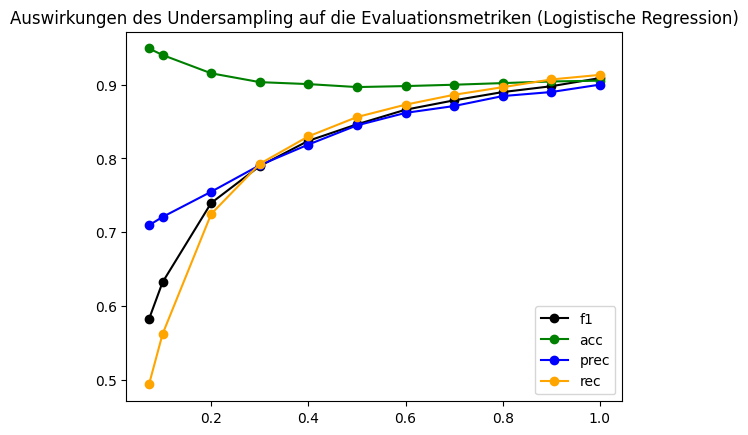

In [13]:
x = [0.072]+[0.1*i for i in range(1,11)]
f1= [f10]+[apply(i)[1] for i in x[1:]]
acc= [acc0]+[apply(i)[0] for i in x[1:]]
prec= [prec0]+[apply(i)[2] for i in x[1:]]
rec= [rec0]+[apply(i)[3] for i in x[1:]]
plt.plot(x,f1,color='black',marker='o',label='f1')
plt.plot(x,acc,color='green',marker='o',label='acc')
plt.plot(x,prec,color='blue',marker='o',label='prec')
plt.plot(x,rec,color='orange',marker='o',label='rec')
plt.legend()
plt.title('Auswirkungen des Undersampling auf die Evaluationsmetriken (Logistische Regression)')

In [17]:
def oversample(rate):
    train_xu, train_yu = SMOTE(sampling_strategy=rate).fit_resample(train_x, train_y)
    test_xu, test_yu = test_x, test_y
    return train_xu, train_yu, test_xu, test_yu

def apply_1(rate):
    train_xu, train_yu, test_xu, test_yu = oversample(rate)
    acc, f1, prec, rec = apply_classifier(train_xu, train_yu, test_xu, test_yu, LogisticRegression(max_iter=500))
    return acc, f1, prec, rec



In [21]:
acc0, f10, prec0, rec0 = apply_classifier(train_x, train_y, test_x, test_y, LogisticRegression(max_iter=500))
x = [0.072]+[0.1*i for i in range(1,11)]
y = [apply_1(i) for i in x[1:]]

Text(0.5, 1.0, 'Auswirkungen des Oversampling auf die Evaluationsmetriken (Logistische Regression)')

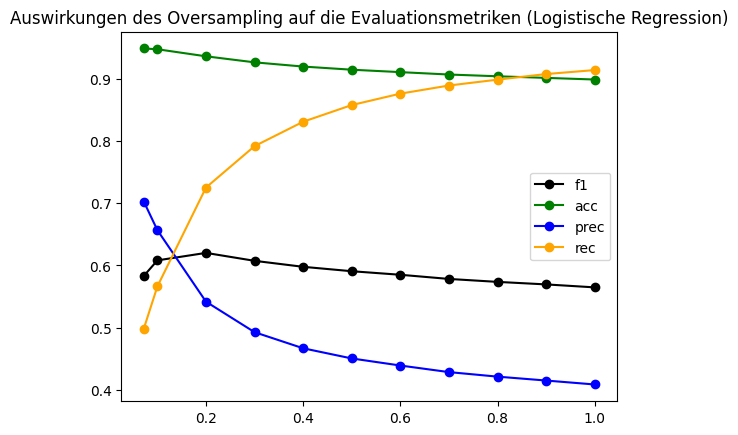

In [20]:

f1= [f10]+[y[i][1] for i in range(0,10)]
acc= [acc0]+[y[i][0] for i in range(0,10)]
prec= [prec0]+[y[i][2] for i in range(0,10)]
rec= [rec0]+[y[i][3] for i in range(0,10)]
plt.plot(x,f1,color='black',marker='o',label='f1')
plt.plot(x,acc,color='green',marker='o',label='acc')
plt.plot(x,prec,color='blue',marker='o',label='prec')
plt.plot(x,rec,color='orange',marker='o',label='rec')
plt.legend()
plt.title('Auswirkungen des Oversampling auf die Evaluationsmetriken (Logistische Regression)')